In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'calc'))

In [2]:
from amm_math import (
    calc_spot_price, calc_out_given_in, calc_in_given_out, 
    set_amm_state, get_amm_spot_prices, get_amm_balance, 
    simple_swap_from_coin, simple_swap_to_coin, simulate_swaps_from_coin,
    calc_balancer_invariant
)

In [3]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
# Weights
w_c, w_l, w_s = sp.symbols('w_c w_l w_s', positive=True)
# Token balances
x_c, x_l, x_s = sp.symbols('x_c x_l x_s', positive=True)
# Prices - in units of locked up collateral
v = sp.symbols('v', positive=True) 
# Swap fee in fraction of input tokens
s_f = sp.symbols('s_f')
# Decimal scaling 
d_c, d_p = sp.symbols('d_c d_p', positive=True)
# Collateral backing L + S 
# e.g. for $100.000_000_000_000_000_000 = 1.000_000 mt
# this is 100*10**18 / 1*10**6 = 10**14
C = sp.symbols('C', positive=True)

In [6]:
help(calc_spot_price)

Help on function calc_spot_price in module amm_math:

calc_spot_price(bI, wI, bO, wO, sF=0)
    calcSpotPrice                                                                             //
     sP = spotPrice                                                                            //
     bI = tokenBalanceIn                ( bI / wI )         1                                  //
     bO = tokenBalanceOut         sP =  -----------  *  ----------                             //
     wI = tokenWeightIn                 ( bO / wO )     ( 1 - sF )                             //
     wO = tokenWeightOut                                                                       //
     sF = swapFee



In [7]:
# e.g. condition for spot price of long token without fees to be v*C
calc_spot_price(x_c, w_c, x_l, w_l) - v*C

-C*v + w_l*x_c/(w_c*x_l)

In [8]:
# Constraint 1: sum of weights is 1
sp.Equality(w_c + w_l + w_s, 1)

Eq(w_c + w_l + w_s, 1)

In [9]:
# Constraint 2: Long token price is v*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_l, w_l, 0), v*C)

Eq(w_l*x_c/(w_c*x_l), C*v)

In [10]:
# Constraint 3: Short token price is (1-v)*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_s, w_s, 0), (1-v)*C)

Eq(w_s*x_c/(w_c*x_s), C*(1 - v))

In [11]:
sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, 0) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])

In [12]:
sp.Equality(w_c, sol[w_c])

Eq(w_c, x_c/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [13]:
sp.Equality(w_l, sol[w_l])

Eq(w_l, C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [14]:
sp.Equality(w_s, sol[w_s])

Eq(w_s, -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [15]:
# Full set of weights needed to set the spot prices of long and short tokens
sol

{w_c: x_c/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_l: C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_s: -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)}

In [16]:
# Check spot prices
calc_spot_price(x_c, w_c, x_l, w_l, s_f).subs(sol) # Long spot price

C*v/(1 - s_f)

In [17]:
calc_spot_price(x_c, w_c, x_s, w_s, s_f).subs(sol)

-C*(v - 1)/(1 - s_f)

In [18]:
# Input token amounts for swaps
a_c, a_l, a_s = sp.symbols('a_c a_l a_s', positive=True)

In [19]:
n, d = sp.fraction(w_c.subs(sol))

In [20]:
w_c.subs(sol).subs({d: 1})

x_c

# Working with AMM State
We now look at the state of the AMM after performing operations such as swapping from C to L or vice versa.

In [21]:
help(set_amm_state)

Help on function set_amm_state in module amm_math:

set_amm_state(x_c, x_l, x_s, v, C, sF=0)
    For fixed token balances calculate the weights needed to achieve
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S



In [22]:
# Check that we get the correct price 
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        100,     # 100 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

In [23]:
# Note that we don't need to have the same number of tokens to achieve equal L and S price
# as the weights can achieve any price
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        10,      # 10 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

## Trading - simple swaps 
Look at what happens when we trade with the pool without using the Mettalex vault to mint and redeem tokens.  We see arbitrage opportunities being created when L + S != C.

To avoid this arbitrage opportunity we can rebalance the pool after each swap so that L + S = C

In [24]:
help(simple_swap_from_coin)

Help on function simple_swap_from_coin in module amm_math:

simple_swap_from_coin(state, aI, to_long=True, sF=0, coin_per_pair=1, rebalance=False, rebalance_fun=<function set_amm_state at 0x7f559d685c20>)
    Swap a_c coins in for specified token (1=L, 2=S)



In [25]:
simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)

([10500,
  90.7029478458050,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 9.29705215419502,
 53.7804878048780)

In [26]:
get_amm_spot_prices(simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)[0])

[57.8812500000000, 52.5000000000000]

In [27]:
help(simple_swap_to_coin)

Help on function simple_swap_to_coin in module amm_math:

simple_swap_to_coin(state, aI, from_long=True, sF=0, coin_per_pair=1, rebalance=False, rebalance_fun=<function set_amm_state at 0x7f559d685c20>)
    Swap position tokens in for coin



In [28]:
simple_swap_to_coin(set_amm_state(10000, 100, 100, 0.5, 100), 1)

([9950.37190209989,
  101,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 49.6280979001085,
 49.6280979001085)

### Price impact for purchasing position tokens 

In [29]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[simple_swap_from_coin(initial_state, c) for c in coin_in])

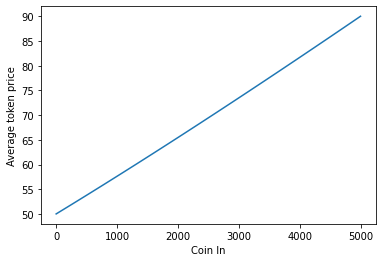

In [30]:
_ = plt.plot(coin_in, avg_price)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Average token price')

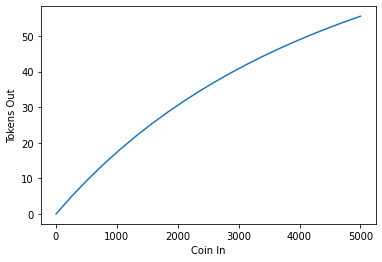

In [31]:
_ = plt.plot(coin_in, tok_out)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Tokens Out')

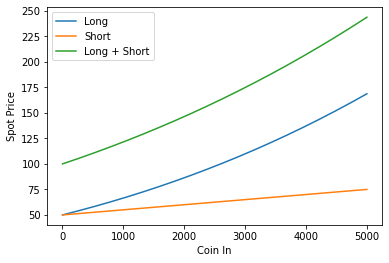

In [32]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

### Price impact for selling position tokens

In [33]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(*[simple_swap_to_coin(initial_state, t) for t in tok_in])

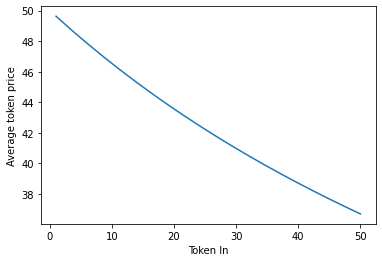

In [34]:
_ = plt.plot(tok_in, avg_price)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Average token price')

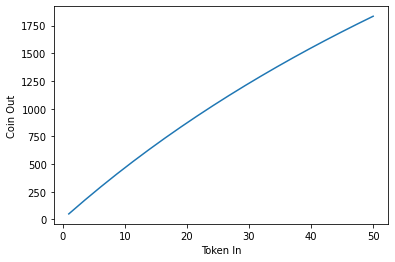

In [35]:
_ = plt.plot(tok_in, coin_out)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Coin Out')

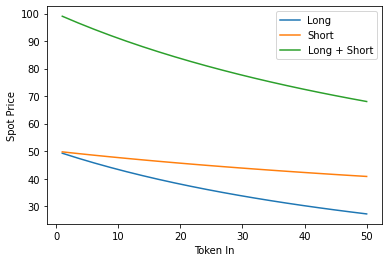

In [36]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

# Pool balance
What is the value of the assets in the pool?  
* A conservative option is to count only coin and paired tokens in which case value is $x_c + \min(x_l, x_s)*C$.  
* A less conservative option uses the spot price of all assets in pool in which case value is $x_c + x_l*v_l*C + x_s*v_s*C$ where the current spot price fractions $v_p, v_s$ reflect the pool spot price taking into account position imbalances i.e. $v_p = \frac{x_c}{x_l}\frac{w_l}{w_c}/C$ etc.

Use the latter value function for the moment and see how we can rebalance the pool after swap to keep the value constant.

In [37]:
help(get_amm_balance)

Help on function get_amm_balance in module amm_math:

get_amm_balance(state)



In [38]:
get_amm_balance(initial_state)

20000.0000000000

In [39]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])
# No rebalancing, raw C->L (or C->S) swap
states_raw, tok_out_raw, avg_price_raw = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])

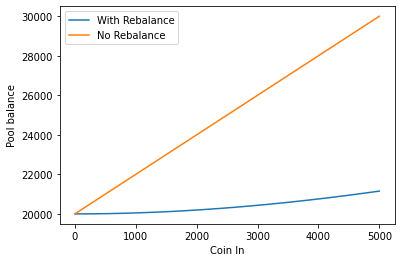

In [40]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
balances_raw = np.array([get_amm_balance(s) for s in states_raw])
_ = plt.plot(coin_in, balances)
_ = plt.plot(coin_in, balances_raw) # No rebalance
_ = plt.legend(['With Rebalance', 'No Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

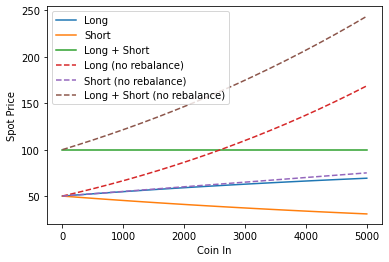

In [41]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
spot_prices_raw = np.array([get_amm_spot_prices(s) for s in states_raw])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.plot(coin_in, spot_prices_raw, linestyle='--')
_ = plt.plot(coin_in, np.sum(spot_prices_raw, axis=1), linestyle='--')
_ = plt.legend(['Long', 'Short', 'Long + Short', 
                'Long (no rebalance)', 'Short (no rebalance)', 'Long + Short (no rebalance)'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

# Swap scenarios
Testing different options to swap coin for position tokens and vice versa, while avoiding arbitrage opportunities and loss of liquidity.  We focus on two key aspects:
* do the spot prices for long and short sum to the value of the undelying collateral?
* does the balance of the autonomous market maker not decrease after a swap? 

In [42]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

In [43]:
get_amm_balance(initial_state)

20000.0000000000

In [44]:
get_amm_spot_prices(initial_state)

[50.0000000000000, 50.0000000000000]

## Original strategy: swap C for L directly

In [45]:
buy_long_no_mint = simple_swap_from_coin(initial_state, 500)[0]

In [46]:
buy_long_no_mint

[10500,
 90.7029478458050,
 100,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [47]:
get_amm_spot_prices(buy_long_no_mint)

[57.8812500000000, 52.5000000000000]

In [48]:
get_amm_balance(buy_long_no_mint)

21000.0000000000

Problem: both token prices go up

### Modification: rebalance to scale weights such that sum of long and short spot price equal collateral
(this was actually the last thing we tried, after the minting during swap option)

In [49]:
buy_long_no_mint_rebalance = simple_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=True)[0]

In [50]:
buy_long_no_mint_rebalance

[10500,
 90.7029478458050,
 100,
 0.524672469623600,
 0.237663765188200,
 0.237663765188200]

In [51]:
get_amm_spot_prices(buy_long_no_mint_rebalance)

[52.4375743162901, 47.5624256837099]

In [52]:
get_amm_balance(buy_long_no_mint_rebalance)

20012.4851367420

In [53]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])

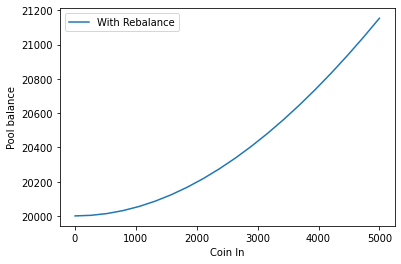

In [54]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(coin_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

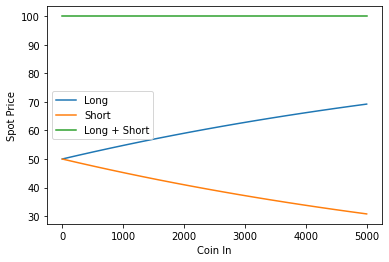

In [55]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

This looks good!  Sum of prices = 100, and balance has increased slightly (even without fees)

## Check swapping position token for coin

In [56]:
sell_long_no_mint_rebalance = simple_swap_to_coin(
    buy_long_no_mint_rebalance, 100-buy_long_no_mint_rebalance[1], coin_per_pair=100, rebalance=True)[0]

In [57]:
get_amm_spot_prices(sell_long_no_mint_rebalance)

[49.9999999999998, 49.9999999999998]

In [58]:
get_amm_balance(sell_long_no_mint_rebalance)

20045.9921189573

So round trip of buy L from AMM, sell L back to AMM results in the AMM gaining money.  See below for a more systematic investigation.

In [59]:
help(simulate_swaps_from_coin)

Help on function simulate_swaps_from_coin in module amm_math:

simulate_swaps_from_coin(x_c_0, x_l_0, x_s_0, v, C, from_coin=True, c_max=1000, n_row=1, offset=0, f=None)



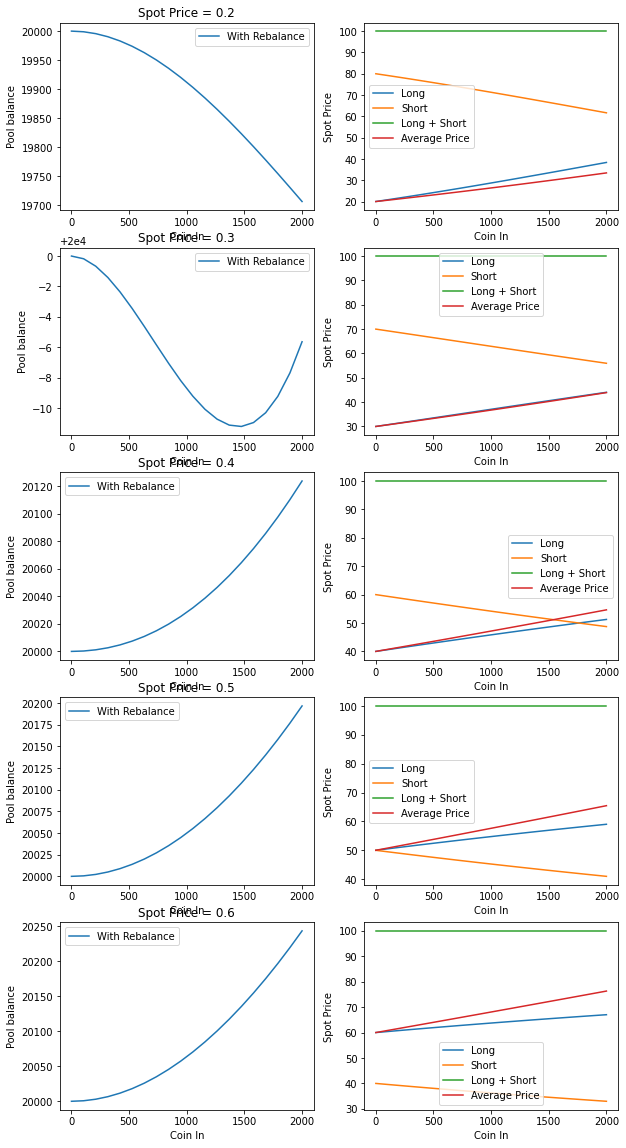

In [60]:
asset_spots = [0.2, 0.3, 0.4, 0.5, 0.6]
n_spots = len(asset_spots)
f = plt.figure(figsize=(10, 4*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=2000, n_row=n_spots, offset=i)
f.savefig('amm_spot_prices.png')

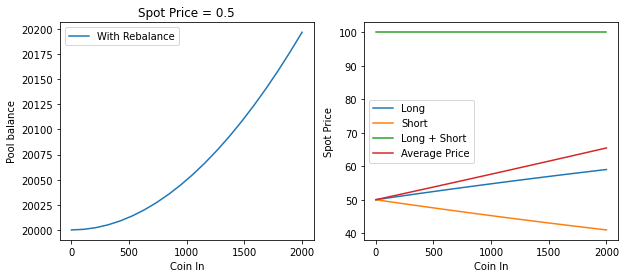

In [61]:
asset_spots = [ 0.5]
n_spots = len(asset_spots)
f = plt.figure(figsize=(10, 4*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=2000, n_row=n_spots, offset=i, f=f)
f.savefig('amm_spot_prices_50.png')

In [62]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(
    *[simple_swap_to_coin(initial_state, t, coin_per_pair=100, rebalance=True) 
      for t in tok_in])

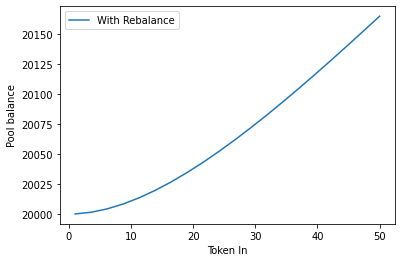

In [63]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(tok_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Pool balance')

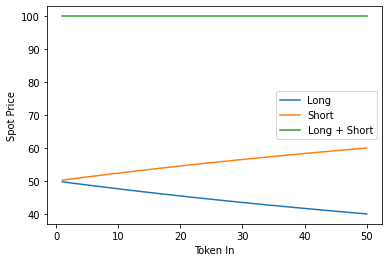

In [64]:
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

In [65]:
calc_balancer_invariant(*initial_state)

1000.00000000000

In [83]:
n_c_0, n_l_0, n_s_0, w_c_0, w_l_0, w_s_0 = initial_state
n_c = np.linspace(n_c_0/2, n_c_0*2, 100)
n_l = np.linspace(n_l_0/2, n_l_0*2, 100)
N_C, N_L = np.meshgrid(n_c, n_l)
S_C_L = calc_spot_price(N_C, w_c_0, N_L, w_l_0, 0)
K_C_L = calc_balancer_invariant(N_C, N_L, n_s_0, w_c_0, w_l_0, w_s_0)

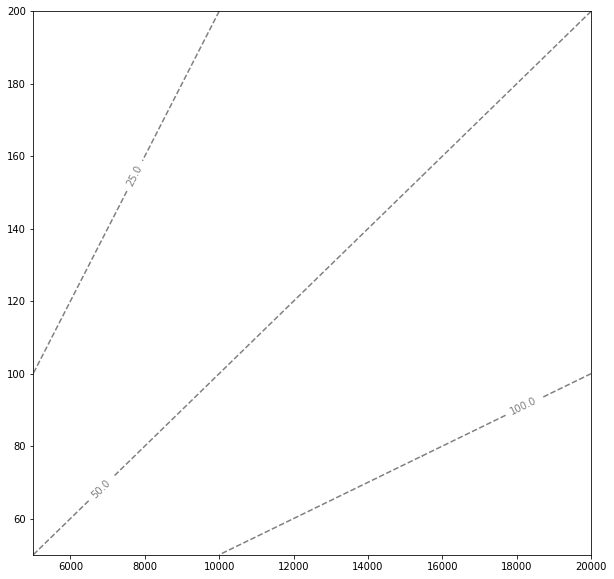

In [84]:
prices = np.array([0.1, 0.25, 0.5, 1, 2., 4, 10.])*100.
f = plt.figure(figsize=(10,10))
c = plt.contour(N_C, N_L, S_C_L, prices, colors='k', alpha=0.5, linestyles='--')
_ = plt.clabel(c, prices, fmt='%0.1f')

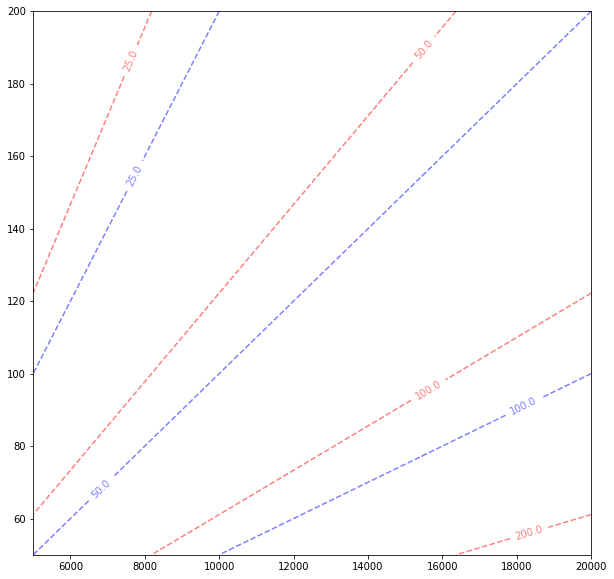

In [90]:
prices = np.array([0.1, 0.25, 0.5, 1, 2., 4, 10.])*100.
f = plt.figure(figsize=(10,10))
c1 = plt.contour(N_C, N_L, calc_spot_price(N_C, w_c_0, N_L, w_l_0, 0), 
                prices, colors='b', alpha=0.5, linestyles='--')
c2 = plt.contour(N_C, N_L, calc_spot_price(N_C, 0.45, N_L, 0.275, 0), 
                prices, colors='r', alpha=0.5, linestyles='--')

_ = plt.clabel(c1, prices, fmt='%0.1f')
_ = plt.clabel(c2, prices, fmt='%0.1f')

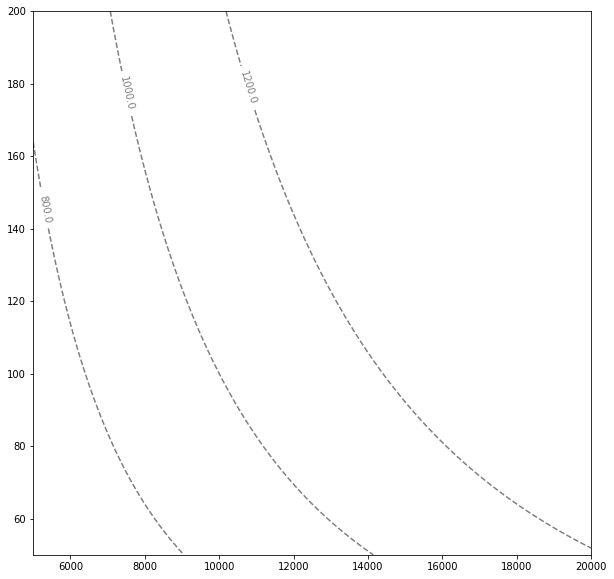

In [91]:
invariants = np.array([0.8, 1.0, 1.2])*1000.
f = plt.figure(figsize=(10,10))
c = plt.contour(N_C, N_L, K_C_L, invariants, colors='k', alpha=0.5, linestyles='--')
_ = plt.clabel(c, invariants, fmt='%0.1f')

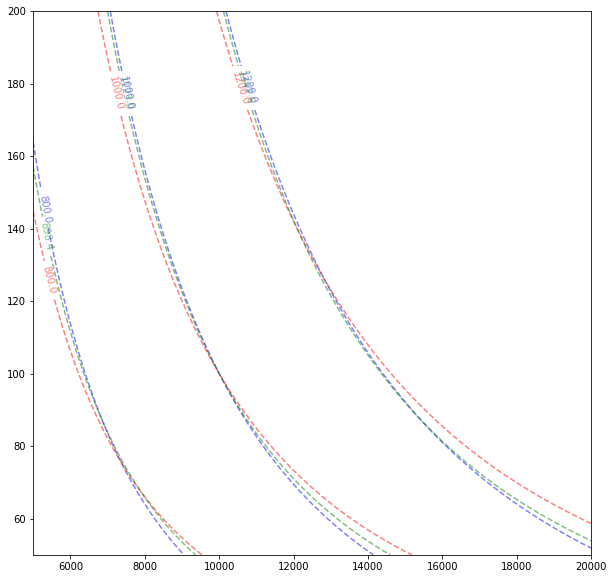

In [101]:
invariants = np.array([0.8, 1.0, 1.2])*1000.
f = plt.figure(figsize=(10,10))
c1 = plt.contour(N_C, N_L, calc_balancer_invariant(N_C, N_L, n_s_0, 0.5, 0.25, 0.25), 
                invariants, colors='b', alpha=0.5, linestyles='--')

invariants_after_buy = np.array([0.8, 1.0, 1.2])*calc_balancer_invariant(*buy_long_no_mint)
c2 = plt.contour(
    N_C, N_L, 
    calc_balancer_invariant(
        N_C + buy_long_no_mint[0] - n_c_0, 
        N_L + buy_long_no_mint[1] - n_l_0, 
        n_s_0, 0.5, 0.25, 0.25), 
    invariants_after_buy,
    colors='r', alpha=0.5, linestyles='--')

n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = buy_long_no_mint_rebalance
invariants_after_buy_rebalance = np.array([0.8, 1.0, 1.2])*calc_balancer_invariant(*buy_long_no_mint_rebalance)
c3 = plt.contour(
    N_C, N_L, 
    calc_balancer_invariant(
        N_C + n_c_1 - n_c_0, 
        N_L +  n_l_1 - n_l_0, 
        n_s_1, w_c_1, w_l_1, w_s_1), 
    invariants_after_buy_rebalance,
    colors='g', alpha=0.5, linestyles='--')


_ = plt.clabel(c1, invariants, fmt='%0.1f')
_ = plt.clabel(c2, invariants_after_buy, fmt='%0.1f')
_ = plt.clabel(c3, invariants_after_buy_rebalance, fmt='%0.1f')